In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary
from torchviz import make_dot

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import logging

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Data Importing

In [5]:
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

In [6]:
# df = pl.read_csv("./.data/train_pp_fe.csv")
# df = df.drop(["id", "time", "hour"] + [col for col in df.columns if col.startswith("p_num_p")])
# df.write_csv("./.data/train_pp_fe.csv")

In [7]:
# df = pl.read_csv("./.data/test_pp_fe.csv")
# df = df.drop(["id", "time", "hour"] + [col for col in df.columns if col.startswith("p_num_p")])
# df.write_csv("./.data/test_pp_fe.csv")

In [8]:
# df = pl.read_csv("./.data/train_pp.csv")
# df = df.drop(["id", "time", "hour_of_day"] + [col for col in df.columns if col.startswith("p_num_p")])
# df.write_csv("./.data/train_pp.csv")

In [9]:
# df = pl.read_csv("./.data/test_pp.csv")
# df = df.drop(["id", "time", "hour_of_day"] + [col for col in df.columns if col.startswith("p_num_p")])
# df.write_csv("./.data/test_pp.csv")

In [10]:
df = pd.read_csv("./.data/train_pp_fe.csv")

In [11]:
print(df)

         bg-5:55   bg-5:50   bg-5:45   bg-5:40   bg-5:35   bg-5:30   bg-5:25  \
0      -1.457519 -1.457525 -1.347369 -1.237367 -1.125705 -1.058866 -0.993040   
1       0.238889  0.239117  0.297732  0.356476  0.414769  0.473156  0.629338   
2       0.671307  0.671594  0.661152  0.650809  0.639595  0.595274  0.551552   
3      -0.027214 -0.027023 -0.093430 -0.159996 -0.226401 -0.148534 -0.070729   
4      -0.093740 -0.093558  0.073022  0.239853  0.406443  0.606376  0.807132   
...          ...       ...       ...       ...       ...       ...       ...   
177019 -0.293317 -0.293163 -0.293173 -0.259958 -0.226401 -0.159635 -0.059617   
177020  0.272152  0.272384  0.272764  0.273174  0.273212  0.273327  0.273748   
177021  1.236776  1.037537  0.971863  0.972910  0.906056  0.839509  0.740459   
177022  0.139100  0.106047  0.172893  0.206533  0.306520  0.406547  0.473767   
177023  0.504992  0.638327  0.705539  0.673023  0.606288  0.573071  0.507104   

         bg-5:20   bg-5:15   bg-5:10  .

In [12]:
for col in df.columns:
    print(col)

bg-5:55
bg-5:50
bg-5:45
bg-5:40
bg-5:35
bg-5:30
bg-5:25
bg-5:20
bg-5:15
bg-5:10
bg-5:05
bg-5:00
bg-4:55
bg-4:50
bg-4:45
bg-4:40
bg-4:35
bg-4:30
bg-4:25
bg-4:20
bg-4:15
bg-4:10
bg-4:05
bg-4:00
bg-3:55
bg-3:50
bg-3:45
bg-3:40
bg-3:35
bg-3:30
bg-3:25
bg-3:20
bg-3:15
bg-3:10
bg-3:05
bg-3:00
bg-2:55
bg-2:50
bg-2:45
bg-2:40
bg-2:35
bg-2:30
bg-2:25
bg-2:20
bg-2:15
bg-2:10
bg-2:05
bg-2:00
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-5:55
insulin-5:50
insulin-5:45
insulin-5:40
insulin-5:35
insulin-5:30
insulin-5:25
insulin-5:20
insulin-5:15
insulin-5:10
insulin-5:05
insulin-5:00
insulin-4:55
insulin-4:50
insulin-4:45
insulin-4:40
insulin-4:35
insulin-4:30
insulin-4:25
insulin-4:20
insulin-4:15
insulin-4:10
insulin-4:05
insulin-4:00
insulin-3:55
insulin-3:50
insulin-3:45
insulin-3:40
insulin-3:35
insulin-3:30
insulin-3:25
insulin-3:20
insulin-

### Data Splitting

In [13]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [14]:
print(f"Train Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (123916, 441)
Validation Shape: (26554, 441)
Test Shape: (26554, 441)


### Dataset and DataLoader

In [15]:
class GDataset(Dataset):
    def __init__(self, df):
        self.n_samples = len(df)
        data = df.values
        self.seq_data = data[:, :432].astype(np.float32).reshape(self.n_samples, 6, 72)
        self.eng_data = data[:, 433:441].astype(np.float32)
        self.targets = data[:, 432].astype(np.float32)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.seq_data[idx], self.eng_data[idx], self.targets[idx]

In [16]:
train_dataset = GDataset(train_df)
val_dataset = GDataset(val_df)
test_dataset = GDataset(test_df)

In [17]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [18]:
class Chomp(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

In [19]:
class MultiScaleTemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation, dropout, kernel_sizes=[3, 5, 7]):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = (k - 1) * dilation
            branch = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=k, padding=padding, dilation=dilation),
                Chomp(padding),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.branches.append(branch)
        self.conv1x1 = nn.Conv1d(out_channels * len(kernel_sizes), out_channels, kernel_size=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        branch_outputs = [branch(x) for branch in self.branches]
        out = torch.cat(branch_outputs, dim=1)
        out = self.conv1x1(out)
        out = self.relu(out)
        out = self.dropout(out)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

In [20]:
class MultiScaleTCN(nn.Module):
    def __init__(self, num_inputs, num_channels, dropout=0.2, kernel_sizes=[3, 5, 7]):
        super(MultiScaleTCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            dilation = 2 ** i
            layers.append(MultiScaleTemporalBlock(in_channels, out_channels, dilation, dropout, kernel_sizes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [21]:
class TCN(nn.Module):
    def __init__(self, seq_in_channels, tcn_channels, dropout, engineered_dim, fc_hidden_dim, kernel_sizes=[3, 5, 7]):
        super(TCN, self).__init__()
        self.tcn = MultiScaleTCN(num_inputs=seq_in_channels, num_channels=tcn_channels,
                                dropout=dropout, kernel_sizes=kernel_sizes)
        self.engineered_net = nn.Sequential(
            nn.Linear(engineered_dim, fc_hidden_dim),
            nn.ReLU(),
            nn.Linear(fc_hidden_dim, fc_hidden_dim),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(tcn_channels[-1] + fc_hidden_dim, fc_hidden_dim),
            nn.ReLU(),
            nn.Linear(fc_hidden_dim, 1)
        )

    def forward(self, x_seq, x_eng):
        out_seq = self.tcn(x_seq)
        out_seq = torch.mean(out_seq, dim=2)
        out_eng = self.engineered_net(x_eng)
        x_cat = torch.cat([out_seq, out_eng], dim=1)
        out = self.fc(x_cat)
        return out.squeeze(1)

In [22]:
model = TCN(seq_in_channels=6, tcn_channels=[128, 128, 128],
            dropout=0.2, engineered_dim=8, fc_hidden_dim=128, kernel_sizes=[3, 5, 7])
model.to(device)

TCN(
  (tcn): MultiScaleTCN(
    (network): Sequential(
      (0): MultiScaleTemporalBlock(
        (branches): ModuleList(
          (0): Sequential(
            (0): Conv1d(6, 128, kernel_size=(3,), stride=(1,), padding=(2,))
            (1): Chomp()
            (2): ReLU()
            (3): Dropout(p=0.2, inplace=False)
          )
          (1): Sequential(
            (0): Conv1d(6, 128, kernel_size=(5,), stride=(1,), padding=(4,))
            (1): Chomp()
            (2): ReLU()
            (3): Dropout(p=0.2, inplace=False)
          )
          (2): Sequential(
            (0): Conv1d(6, 128, kernel_size=(7,), stride=(1,), padding=(6,))
            (1): Chomp()
            (2): ReLU()
            (3): Dropout(p=0.2, inplace=False)
          )
        )
        (conv1x1): Conv1d(384, 128, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
        (dropout): Dropout(p=0.2, inplace=False)
        (downsample): Conv1d(6, 128, kernel_size=(1,), stride=(1,))
      )
      (1): Mult

#### Model Summary

In [23]:
dummy_seq = torch.randn(1, 6, 72).to(device)
dummy_eng = torch.randn(1, 8).to(device)

In [24]:
print("Model Summary:")
print(summary(model, input_data=[dummy_seq, dummy_eng]))

Model Summary:
Layer (type:depth-idx)                        Output Shape              Param #
TCN                                           [1]                       --
├─MultiScaleTCN: 1-1                          [1, 128, 72]              --
│    └─Sequential: 2-1                        [1, 128, 72]              --
│    │    └─MultiScaleTemporalBlock: 3-1      [1, 128, 72]              62,080
│    │    └─MultiScaleTemporalBlock: 3-2      [1, 128, 72]              295,424
│    │    └─MultiScaleTemporalBlock: 3-3      [1, 128, 72]              295,424
├─Sequential: 1-2                             [1, 128]                  --
│    └─Linear: 2-2                            [1, 128]                  1,152
│    └─ReLU: 2-3                              [1, 128]                  --
│    └─Linear: 2-4                            [1, 128]                  16,512
│    └─ReLU: 2-5                              [1, 128]                  --
├─Sequential: 1-3                             [1, 1]       

#### Model Computational Graph

In [25]:
dummy_output = model(dummy_seq, dummy_eng)
dot = make_dot(dummy_output, params=dict(model.named_parameters()))

Model Computational Graph:


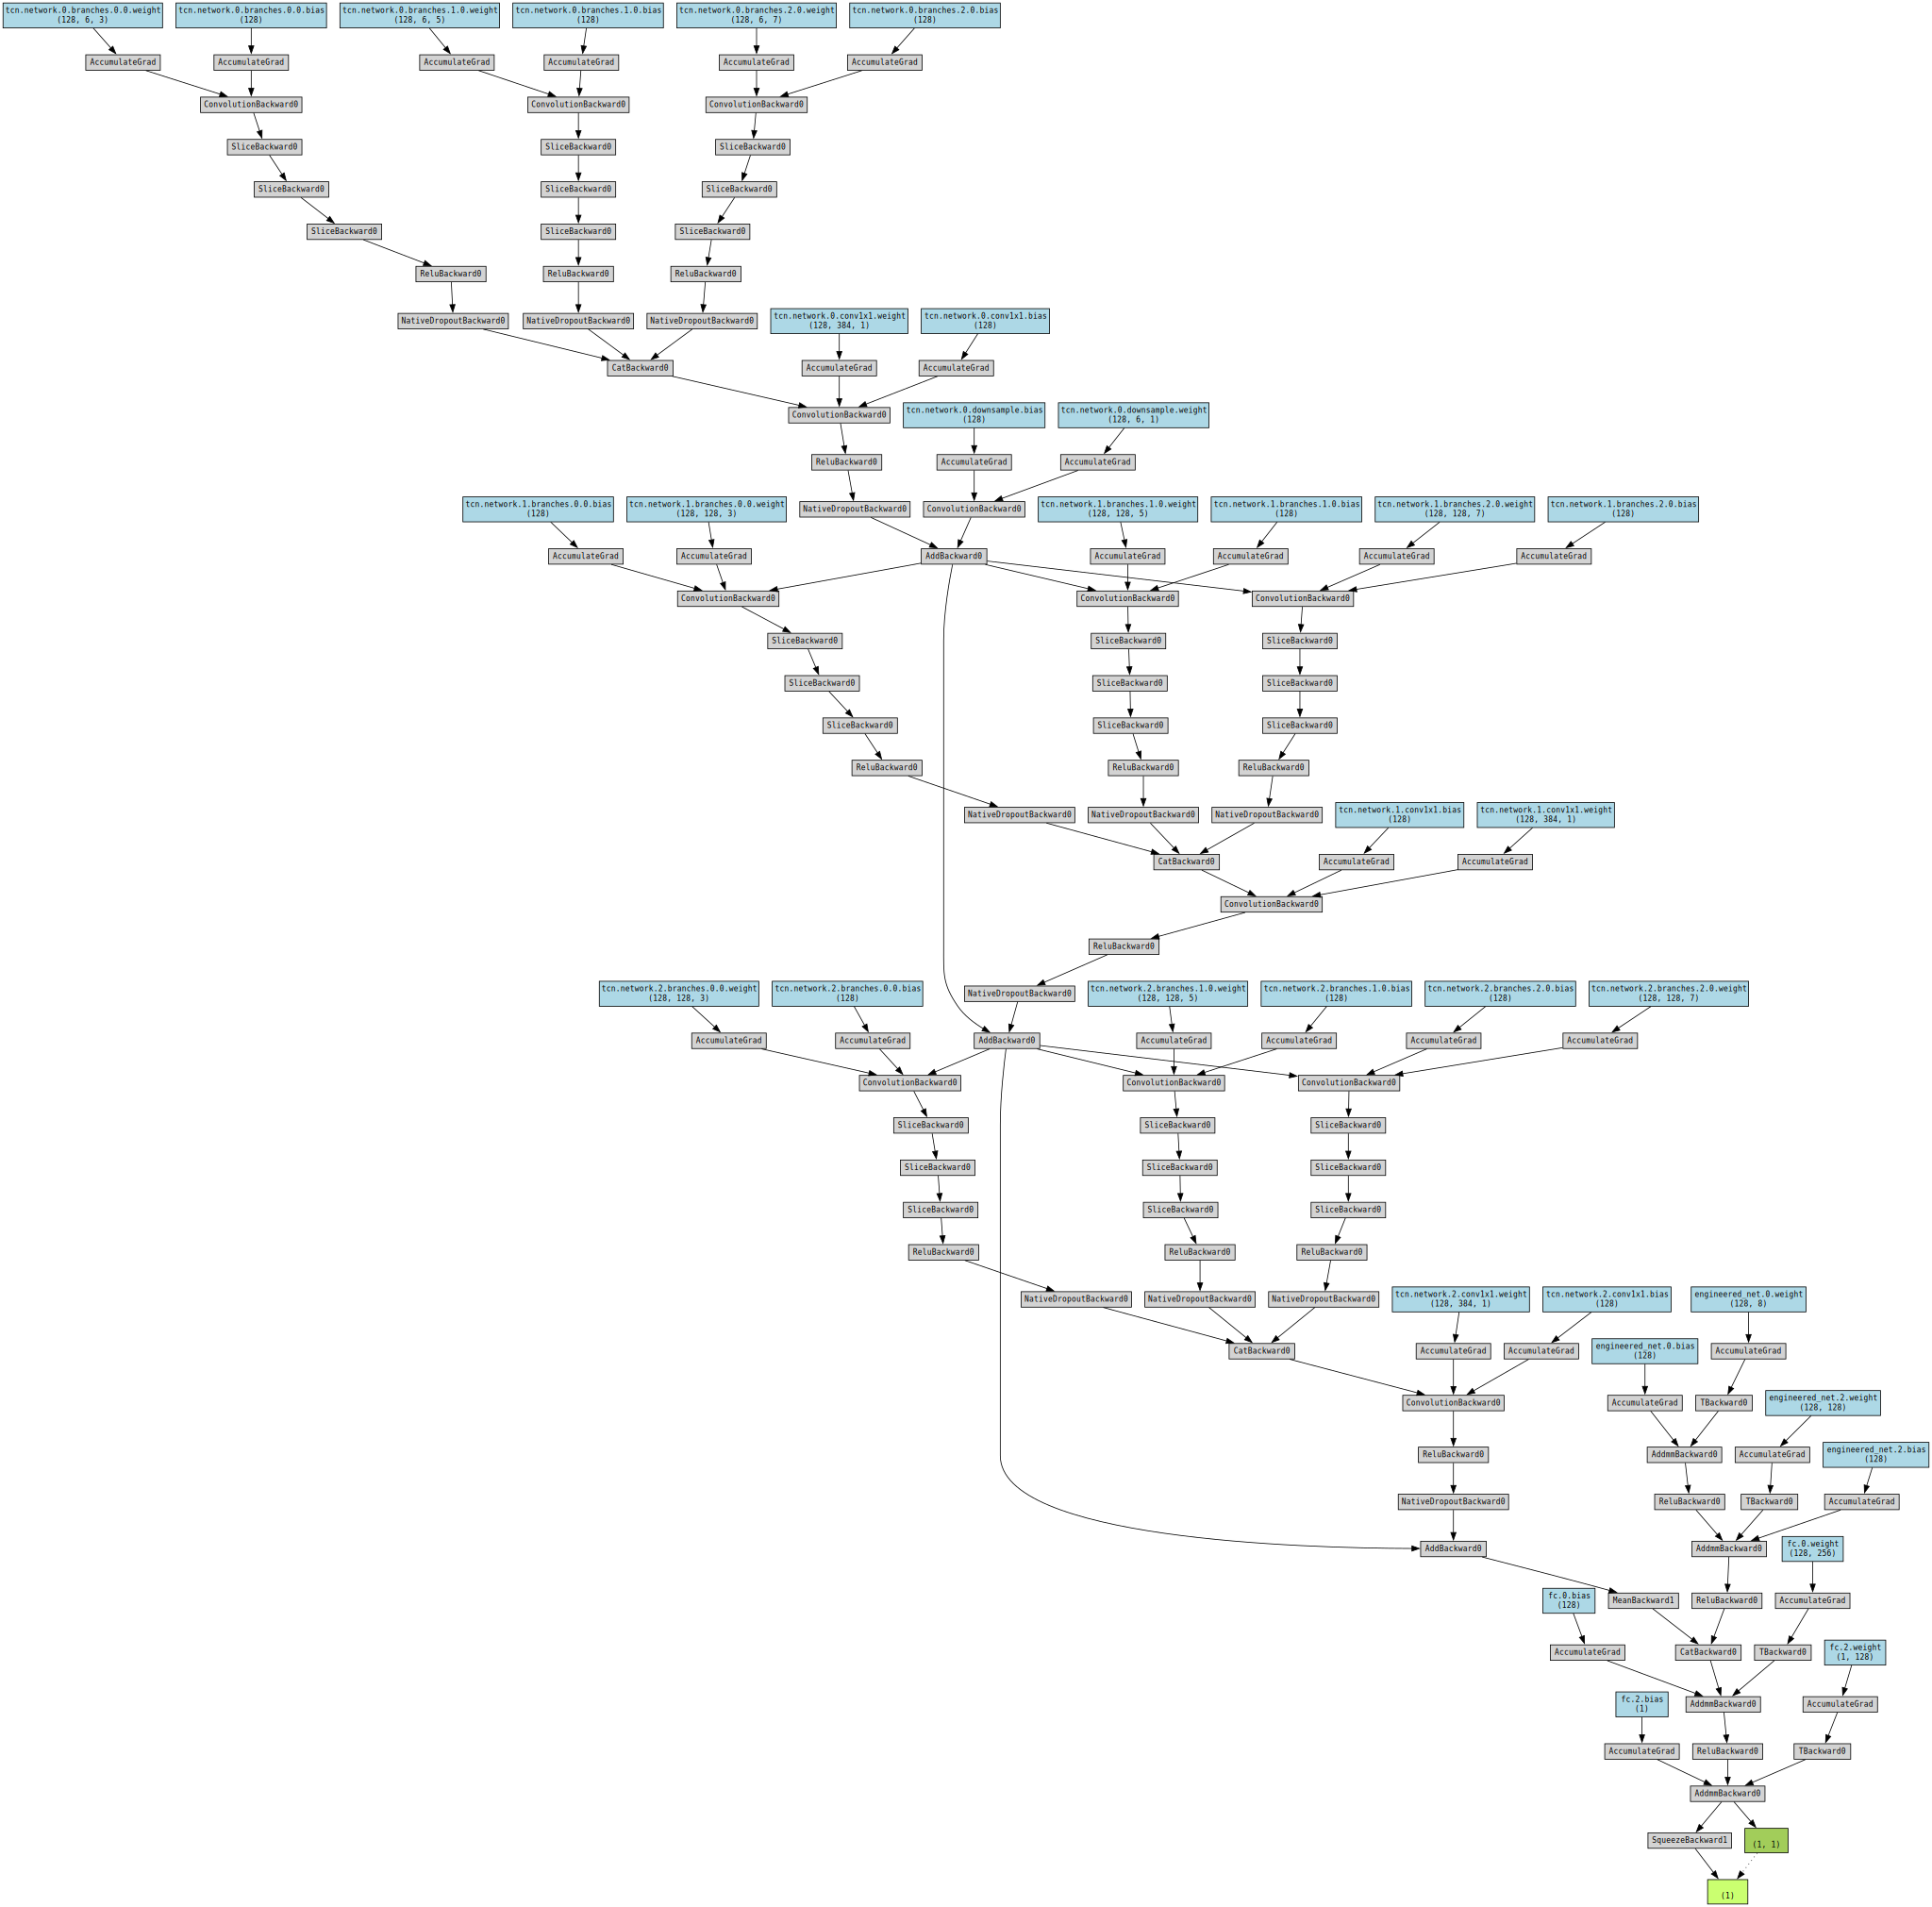

In [26]:
print("Model Computational Graph:")
display(dot)

### Training

In [27]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), './.export/checkpoint.pt')
        self.val_loss_min = val_loss

In [29]:
early_stopping = EarlyStopping(patience=5, verbose=True)
num_epochs = 100
train_losses = []
val_losses = []

In [30]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#             profile_memory=True,
#             record_shapes=True) as prof:

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0

#         for x_seq, x_eng, targets in tqdm(train_loader, desc=f"Epoch: {epoch+1} (Train)"):
#             x_seq = x_seq.to(device)
#             x_eng = x_eng.to(device)
#             targets = targets.to(device)

#             optimizer.zero_grad()

#             with record_function("Forward Pass"):
#                 outputs = model(x_seq, x_eng)

#             with record_function("Compute Loss"):
#                 loss = criterion(outputs, targets)

#             with record_function("Backward Pass"):
#                 loss.backward()

#             with record_function("Optimizer Step"):
#                 optimizer.step()

#             running_loss += loss.item() * x_seq.size(0)

#         train_loss = running_loss / len(train_loader.dataset)
#         train_losses.append(train_loss)

#         model.eval()
#         val_running_loss = 0.0
#         with torch.no_grad():
#             for x_seq, x_eng, targets in tqdm(val_loader, desc=f"Epoch: {epoch+1} (Validation)"):
#                 x_seq = x_seq.to(device)
#                 x_eng = x_eng.to(device)
#                 targets = targets.to(device)
#                 outputs = model(x_seq, x_eng)
#                 loss = criterion(outputs, targets)
#                 val_running_loss += loss.item() * x_seq.size(0)

#         val_loss = val_running_loss / len(val_loader.dataset)
#         val_losses.append(val_loss)

#         print(f"Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#         early_stopping(val_loss, model)
#         if early_stopping.early_stop:
#             print("Early Stopping!")
#             break

In [31]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x_seq, x_eng, targets in tqdm(train_loader, desc=f"Epoch: {epoch+1} (Train)"):
        x_seq = x_seq.to(device)
        x_eng = x_eng.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(x_seq, x_eng)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_seq.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for x_seq, x_eng, targets in tqdm(val_loader, desc=f"Epoch: {epoch+1} (Validation)"):
            x_seq = x_seq.to(device)
            x_eng = x_eng.to(device)
            targets = targets.to(device)
            outputs = model(x_seq, x_eng)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * x_seq.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early Stopping!")
        break

Epoch: 1 (Validation): 100%|██████████| 415/415 [00:01<00:00, 269.62it/s]


Epoch: 1/100 | Train Loss: 4.6184 | Val Loss: 4.5122


Epoch: 2 (Validation): 100%|██████████| 415/415 [00:01<00:00, 275.33it/s]


Epoch: 2/100 | Train Loss: 4.0787 | Val Loss: 3.9137


Epoch: 3 (Validation): 100%|██████████| 415/415 [00:01<00:00, 268.21it/s]


Epoch: 3/100 | Train Loss: 3.8510 | Val Loss: 3.6212


Epoch: 4 (Validation): 100%|██████████| 415/415 [00:01<00:00, 271.61it/s]


Epoch: 4/100 | Train Loss: 3.6162 | Val Loss: 3.9583
EarlyStopping: 1/5


Epoch: 5 (Validation): 100%|██████████| 415/415 [00:01<00:00, 263.51it/s]


Epoch: 5/100 | Train Loss: 3.3516 | Val Loss: 3.1542


Epoch: 6 (Validation): 100%|██████████| 415/415 [00:01<00:00, 261.50it/s]


Epoch: 6/100 | Train Loss: 3.1105 | Val Loss: 2.8213


Epoch: 7 (Validation): 100%|██████████| 415/415 [00:01<00:00, 255.78it/s]


Epoch: 7/100 | Train Loss: 2.8694 | Val Loss: 2.6283


Epoch: 8 (Validation): 100%|██████████| 415/415 [00:01<00:00, 239.87it/s]


Epoch: 8/100 | Train Loss: 2.6678 | Val Loss: 2.4720


Epoch: 9 (Validation): 100%|██████████| 415/415 [00:01<00:00, 227.92it/s]


Epoch: 9/100 | Train Loss: 2.4929 | Val Loss: 2.3356


Epoch: 10 (Validation): 100%|██████████| 415/415 [00:01<00:00, 264.43it/s]


Epoch: 10/100 | Train Loss: 2.3395 | Val Loss: 2.2077


Epoch: 11 (Validation): 100%|██████████| 415/415 [00:01<00:00, 265.57it/s]


Epoch: 11/100 | Train Loss: 2.2176 | Val Loss: 2.2623
EarlyStopping: 1/5


Epoch: 12 (Validation): 100%|██████████| 415/415 [00:01<00:00, 213.57it/s]


Epoch: 12/100 | Train Loss: 2.0993 | Val Loss: 1.9578


Epoch: 13 (Validation): 100%|██████████| 415/415 [00:01<00:00, 256.93it/s]


Epoch: 13/100 | Train Loss: 2.0094 | Val Loss: 1.9617
EarlyStopping: 1/5


Epoch: 14 (Validation): 100%|██████████| 415/415 [00:01<00:00, 255.92it/s]


Epoch: 14/100 | Train Loss: 1.9327 | Val Loss: 1.8354


Epoch: 15 (Validation): 100%|██████████| 415/415 [00:01<00:00, 275.95it/s]


Epoch: 15/100 | Train Loss: 1.8588 | Val Loss: 1.8115


Epoch: 16 (Validation): 100%|██████████| 415/415 [00:01<00:00, 275.52it/s]


Epoch: 16/100 | Train Loss: 1.7747 | Val Loss: 1.7170


Epoch: 17 (Validation): 100%|██████████| 415/415 [00:01<00:00, 248.04it/s]


Epoch: 17/100 | Train Loss: 1.7330 | Val Loss: 1.7562
EarlyStopping: 1/5


Epoch: 18 (Validation): 100%|██████████| 415/415 [00:01<00:00, 285.93it/s]


Epoch: 18/100 | Train Loss: 1.6575 | Val Loss: 1.6046


Epoch: 19 (Validation): 100%|██████████| 415/415 [00:01<00:00, 246.91it/s]


Epoch: 19/100 | Train Loss: 1.6087 | Val Loss: 1.5518


Epoch: 20 (Validation): 100%|██████████| 415/415 [00:01<00:00, 248.36it/s]


Epoch: 20/100 | Train Loss: 1.5789 | Val Loss: 1.5324


Epoch: 21 (Validation): 100%|██████████| 415/415 [00:01<00:00, 237.55it/s]


Epoch: 21/100 | Train Loss: 1.5195 | Val Loss: 1.5161


Epoch: 22 (Validation): 100%|██████████| 415/415 [00:01<00:00, 286.49it/s]


Epoch: 22/100 | Train Loss: 1.4771 | Val Loss: 1.3895


Epoch: 23 (Validation): 100%|██████████| 415/415 [00:01<00:00, 277.93it/s]


Epoch: 23/100 | Train Loss: 1.4393 | Val Loss: 1.4035
EarlyStopping: 1/5


Epoch: 24 (Validation): 100%|██████████| 415/415 [00:01<00:00, 239.24it/s]


Epoch: 24/100 | Train Loss: 1.4205 | Val Loss: 1.3357


Epoch: 25 (Validation): 100%|██████████| 415/415 [00:02<00:00, 197.40it/s]


Epoch: 25/100 | Train Loss: 1.3817 | Val Loss: 1.4001
EarlyStopping: 1/5


Epoch: 26 (Validation): 100%|██████████| 415/415 [00:01<00:00, 244.68it/s]


Epoch: 26/100 | Train Loss: 1.3520 | Val Loss: 1.3890
EarlyStopping: 2/5


Epoch: 27 (Validation): 100%|██████████| 415/415 [00:01<00:00, 221.23it/s]


Epoch: 27/100 | Train Loss: 1.3242 | Val Loss: 1.3596
EarlyStopping: 3/5


Epoch: 28 (Validation): 100%|██████████| 415/415 [00:01<00:00, 262.81it/s]


Epoch: 28/100 | Train Loss: 1.3008 | Val Loss: 1.3057


Epoch: 29 (Validation): 100%|██████████| 415/415 [00:01<00:00, 252.59it/s]


Epoch: 29/100 | Train Loss: 1.2704 | Val Loss: 1.3314
EarlyStopping: 1/5


Epoch: 30 (Validation): 100%|██████████| 415/415 [00:01<00:00, 209.28it/s]


Epoch: 30/100 | Train Loss: 1.2496 | Val Loss: 1.2352


Epoch: 31 (Validation): 100%|██████████| 415/415 [00:01<00:00, 275.18it/s]


Epoch: 31/100 | Train Loss: 1.2254 | Val Loss: 1.2953
EarlyStopping: 1/5


Epoch: 32 (Validation): 100%|██████████| 415/415 [00:01<00:00, 275.75it/s]


Epoch: 32/100 | Train Loss: 1.2056 | Val Loss: 1.2424
EarlyStopping: 2/5


Epoch: 33 (Validation): 100%|██████████| 415/415 [00:01<00:00, 247.99it/s]


Epoch: 33/100 | Train Loss: 1.1876 | Val Loss: 1.1934


Epoch: 34 (Validation): 100%|██████████| 415/415 [00:01<00:00, 270.11it/s]


Epoch: 34/100 | Train Loss: 1.1646 | Val Loss: 1.2074
EarlyStopping: 1/5


Epoch: 35 (Validation): 100%|██████████| 415/415 [00:01<00:00, 243.19it/s]


Epoch: 35/100 | Train Loss: 1.1496 | Val Loss: 1.1917


Epoch: 36 (Validation): 100%|██████████| 415/415 [00:01<00:00, 250.28it/s]


Epoch: 36/100 | Train Loss: 1.1400 | Val Loss: 1.2017
EarlyStopping: 1/5


Epoch: 37 (Validation): 100%|██████████| 415/415 [00:01<00:00, 256.16it/s]


Epoch: 37/100 | Train Loss: 1.1127 | Val Loss: 1.1679


Epoch: 38 (Validation): 100%|██████████| 415/415 [00:01<00:00, 275.46it/s]


Epoch: 38/100 | Train Loss: 1.1107 | Val Loss: 1.1574


Epoch: 39 (Validation): 100%|██████████| 415/415 [00:01<00:00, 271.28it/s]


Epoch: 39/100 | Train Loss: 1.0876 | Val Loss: 1.1327


Epoch: 40 (Validation): 100%|██████████| 415/415 [00:01<00:00, 285.03it/s]


Epoch: 40/100 | Train Loss: 1.0743 | Val Loss: 1.1388
EarlyStopping: 1/5


Epoch: 41 (Validation): 100%|██████████| 415/415 [00:01<00:00, 247.54it/s]


Epoch: 41/100 | Train Loss: 1.0533 | Val Loss: 1.0654


Epoch: 42 (Validation): 100%|██████████| 415/415 [00:01<00:00, 281.20it/s]


Epoch: 42/100 | Train Loss: 1.0521 | Val Loss: 1.0622


Epoch: 43 (Validation): 100%|██████████| 415/415 [00:01<00:00, 274.85it/s]


Epoch: 43/100 | Train Loss: 1.0389 | Val Loss: 1.1731
EarlyStopping: 1/5


Epoch: 44 (Validation): 100%|██████████| 415/415 [00:01<00:00, 254.94it/s]


Epoch: 44/100 | Train Loss: 1.0245 | Val Loss: 1.0485


Epoch: 45 (Validation): 100%|██████████| 415/415 [00:01<00:00, 233.59it/s]


Epoch: 45/100 | Train Loss: 1.0230 | Val Loss: 1.0258


Epoch: 46 (Validation): 100%|██████████| 415/415 [00:01<00:00, 241.64it/s]


Epoch: 46/100 | Train Loss: 1.0012 | Val Loss: 1.0395
EarlyStopping: 1/5


Epoch: 47 (Validation): 100%|██████████| 415/415 [00:01<00:00, 249.98it/s]


Epoch: 47/100 | Train Loss: 0.9917 | Val Loss: 1.0765
EarlyStopping: 2/5


Epoch: 48 (Validation): 100%|██████████| 415/415 [00:01<00:00, 248.94it/s]


Epoch: 48/100 | Train Loss: 0.9820 | Val Loss: 1.0232


Epoch: 49 (Validation): 100%|██████████| 415/415 [00:01<00:00, 253.45it/s]


Epoch: 49/100 | Train Loss: 0.9752 | Val Loss: 1.0066


Epoch: 50 (Validation): 100%|██████████| 415/415 [00:01<00:00, 262.09it/s]


Epoch: 50/100 | Train Loss: 0.9684 | Val Loss: 1.0331
EarlyStopping: 1/5


Epoch: 51 (Validation): 100%|██████████| 415/415 [00:01<00:00, 213.70it/s]


Epoch: 51/100 | Train Loss: 0.9579 | Val Loss: 1.0476
EarlyStopping: 2/5


Epoch: 52 (Validation): 100%|██████████| 415/415 [00:01<00:00, 235.45it/s]


Epoch: 52/100 | Train Loss: 0.9499 | Val Loss: 1.0430
EarlyStopping: 3/5


Epoch: 53 (Validation): 100%|██████████| 415/415 [00:01<00:00, 264.13it/s]


Epoch: 53/100 | Train Loss: 0.9432 | Val Loss: 1.0246
EarlyStopping: 4/5


Epoch: 54 (Validation): 100%|██████████| 415/415 [00:01<00:00, 240.06it/s]

Epoch: 54/100 | Train Loss: 0.9281 | Val Loss: 1.0282
EarlyStopping: 5/5
Early Stopping!


In [32]:
# print("Training Performance:")
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

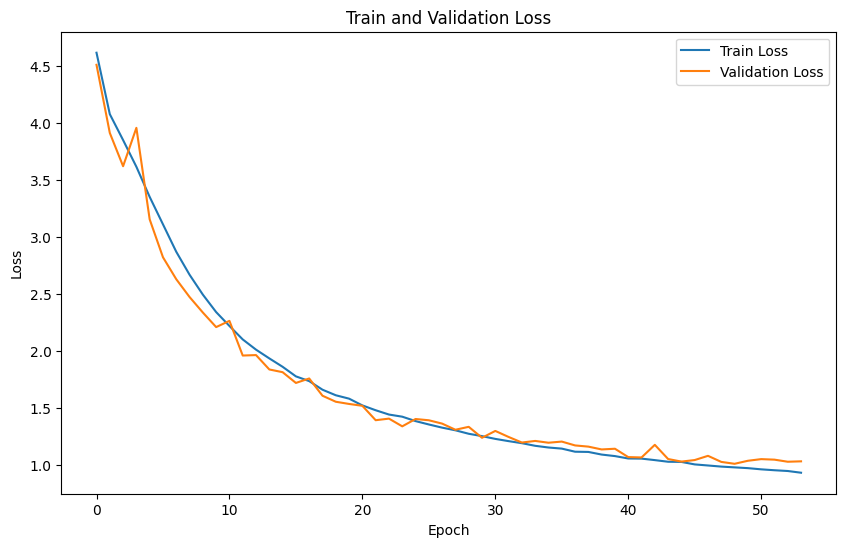

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()

### Evaluation

In [34]:
model.load_state_dict(torch.load('./.export/checkpoint.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11120\941389642.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint.pt'))


<All keys matched successfully>

In [35]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

def mae(pred, target):
    return np.mean(np.abs(pred - target))

def mard(pred, target):
    return np.mean(np.abs(pred - target) / (np.abs(target) + 1e-6))

def mbe(pred, target):
    return np.mean(pred - target)

def mape(pred, target):
    return np.mean(np.abs((target - pred) / (target + 1e-6))) * 100

def pearson_r(pred, target):
    return np.corrcoef(pred, target)[0, 1]

def ccc(pred, target):
    pred_mean = np.mean(pred)
    target_mean = np.mean(target)
    pred_var = np.var(pred)
    target_var = np.var(target)
    covariance = np.mean((pred - pred_mean) * (target - target_mean))
    return (2 * covariance) / (pred_var + target_var + (pred_mean - target_mean)**2 + 1e-6)

In [36]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_seq, x_eng, targets in tqdm(test_loader, desc="Evaluation"):
        x_seq = x_seq.to(device)
        x_eng = x_eng.to(device)
        targets = targets.to(device)
        outputs = model(x_seq, x_eng)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
        
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

Evaluation: 100%|██████████| 415/415 [00:02<00:00, 203.03it/s]


In [37]:
from sklearn.metrics import r2_score
test_r2 = r2_score(all_targets, all_preds)

In [38]:
from sklearn.metrics import explained_variance_score
test_expl_var = explained_variance_score(all_targets, all_preds)

In [39]:
test_rmse = rmse(all_preds, all_targets)
test_mae = mae(all_preds, all_targets)
test_mard = mard(all_preds, all_targets)

test_mbe = mbe(all_preds, all_targets)
test_r2 = r2_score(all_targets, all_preds)
test_expl_var = explained_variance_score(all_targets, all_preds)
test_mape = mape(all_preds, all_targets)
test_pearson = pearson_r(all_preds, all_targets)
test_ccc = ccc(all_preds, all_targets)

In [40]:
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MARD: {test_mard:.4f}")
print(f"Test MBE: {test_mbe:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Explained Variance: {test_expl_var:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test Pearson r: {test_pearson:.4f}")
print(f"Test CCC: {test_ccc:.4f}")

Test RMSE: 0.9966
Test MAE: 0.7490
Test MARD: 0.0978
Test MBE: -0.1503
Test R²: 0.8888
Test Explained Variance: 0.8913
Test MAPE: 9.78%
Test Pearson r: 0.9462
Test CCC: 0.9450
